In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
plt.ion()

In [2]:
def filter_matrix(src_filename, well, win):
    # Load data from the specified source file
    with open(src_filename, 'rb') as f:
        data = pkl.load(f)

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well][win]['adj_matrix_predicted']
    votes = data[well][win]['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well][win]['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

##  Week 5.5 to 8.5 (run 8 and LD)/LD Chip M5898 ('well003', 'win_0', 932.8, 44232.2) 

In [6]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/March 30 2024/TimeCourseData_ecr_results_windowed/Raw Data Week 5.5 to 8.5 (run 8 and LD)/LD'
#dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/March 30 2024/TimeCourseData_ecr_results_windowed/Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8'
#dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/March 30 2024/TimeCourseData_ecr_results_windowed/Raw Data Week 9.5 to 12.5 (run 6 and 7)/Run 7'
os.chdir(dr)

In [3]:
filenames=os.listdir(dr)
filenames
filenames.pop(2)


NameError: name 'dr' is not defined

In [8]:
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('DIV ')[1]))
#sorted_filenames_updated = [filename + '/data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
sorted_filenames_updated = [filename + '/M05898data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
#sorted_filenames_updated = [filename + '/M05912data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
sorted_filenames_updated

['DIV 3/M05898data.raw_20240326_18h20m.pkl',
 'DIV 5/M05898data.raw_20240326_18h20m.pkl',
 'DIV 7/M05898data.raw_20240326_18h20m.pkl',
 'DIV 9/M05898data.raw_20240326_18h20m.pkl',
 'DIV 11/M05898data.raw_20240326_18h20m.pkl',
 'DIV 13/M05898data.raw_20240326_18h20m.pkl',
 'DIV 15/M05898data.raw_20240326_18h20m.pkl',
 'DIV 17/M05898data.raw_20240326_18h20m.pkl',
 'DIV 19/M05898data.raw_20240326_18h20m.pkl',
 'DIV 21/M05898data.raw_20240326_18h20m.pkl']

In [9]:
well= 'well003'
win= 'win_0'

In [10]:
m = len(sorted_filenames_updated)
all_adj = []
for i in range(m):
    try:
        adj = filter_matrix(sorted_filenames_updated[i],well,win)
        all_adj.append(adj)
    except:
        all_adj.append(None)
        print('Error at ', i)

In [11]:
sort_filename=np.empty([m, 3], dtype=object)
sort_filename[:,0]=range(3,22,2)

In [12]:
sort_filename

array([[3, None, None],
       [5, None, None],
       [7, None, None],
       [9, None, None],
       [11, None, None],
       [13, None, None],
       [15, None, None],
       [17, None, None],
       [19, None, None],
       [21, None, None]], dtype=object)

In [13]:
for i in range(0,m):
    mat_data = all_adj[i]
    sort_filename[i,1]=(mat_data.shape[0])
    sort_filename[i,2]=(sum(sum(mat_data>0)))

In [14]:
sort_filename

array([[3, 443, 1],
       [5, 860, 29],
       [7, 963, 589],
       [9, 1000, 1415],
       [11, 1006, 18351],
       [13, 1010, 54048],
       [15, 1010, 84279],
       [17, 1009, 97738],
       [19, 1014, 95052],
       [21, 1013, 90820]], dtype=object)

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


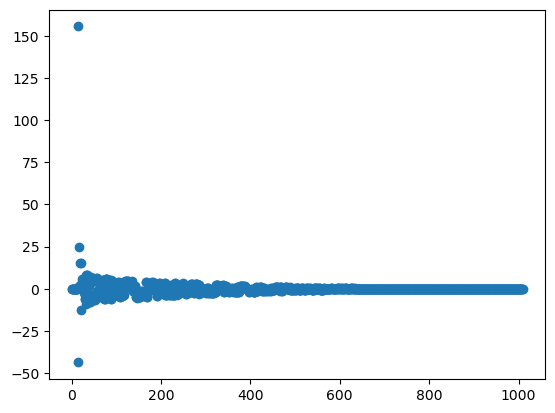

In [13]:
s,u=np.linalg.eig(all_adj[5])
plt.scatter(range(all_adj[5].shape[0]),s)

In [15]:
tm = [4,5,6,7,8,9]  

In [25]:
## add zeros to the adj mat such that they have the same dims 
dim = max(sort_filename[tm, 1])  # Max number of vertices to determine dimension
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size

for i in range(len(tm)):
    ma = all_adj[tm[i]]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [26]:
all_adj[5]

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [27]:
from scipy.optimize import quadratic_assignment
from numpy import linalg as LA

In [33]:
adj_gm=np.zeros([len(tm),dim,dim]) ## use the first graph as baseline
adj_gm[0] = adj_aug[0] 

In [29]:
dim

1014

In [34]:
for i in range(1, len(tm)):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm}")


Frob diff before GM: 263.40273347101015, After GM: 203.58045092788257
Frob diff before GM: 357.783454061252, After GM: 251.52534663528445
Frob diff before GM: 406.2893057908367, After GM: 280.34086394958547
Frob diff before GM: 418.3180608101926, After GM: 286.2271824967014
Frob diff before GM: 411.6527662970334, After GM: 283.6370920736567


In [35]:
## find largest common connected component 
prod=adj_gm[0]
for i in range(1,len(tm)):
    prod=prod * adj_gm[i]

In [36]:
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils

In [38]:
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)

358

In [42]:
n=len(ind)

In [40]:
# double check every adj mat is connected 
glist=np.zeros([len(tm),len(ind),len(ind)])
for i in range(len(tm)):
    glist[i]=adj_gm[i][ind][:,ind]
    print(graspologic_utils.is_fully_connected(glist[i]))

True
True
True
True
True
True


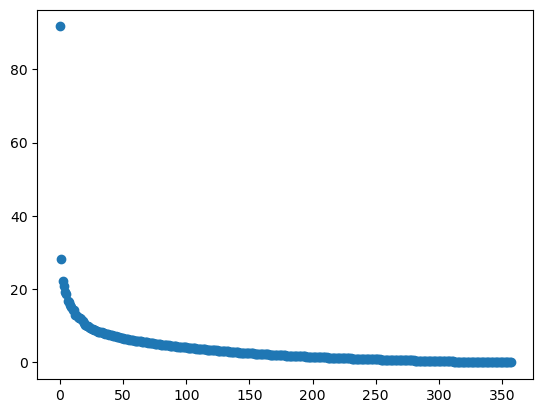

In [43]:
## scree plot for one graph 
u,s,v=np.linalg.svd(glist[0], full_matrices=True)
plt.scatter(range(n),s)

In [44]:
from graspologic.embed import AdjacencySpectralEmbed

In [86]:
ed=4
Xhat_list=np.zeros([len(tm),n,2*ed])
for i in range(len(tm)):
    ase = AdjacencySpectralEmbed(n_components=ed)
    Xhat, Yhat = ase.fit_transform(glist[i])
    Xhat_list[i][:,list(np.arange(ed))]=Xhat
    Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

In [87]:
from scipy.linalg import orthogonal_procrustes
D=np.zeros([len(tm),len(tm)])
for i in range(len(tm)):
    for j in range(len(tm)):
        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  

In [88]:
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

Text(0, 0.5, 'eigen value')

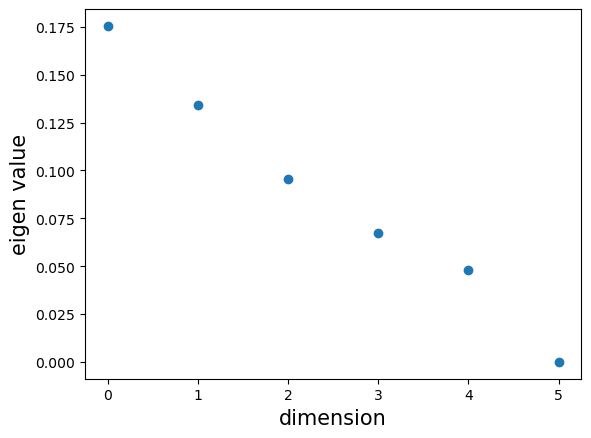

In [89]:
H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

In [90]:
d=4
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

In [91]:
## transform date to days from begining
day=np.zeros([len(tm)])
for i in range(len(tm)):
    day[i]=(sort_filename[tm[i],0]-sort_filename[tm[0],0])

Text(0, 0.5, 'dim 2')

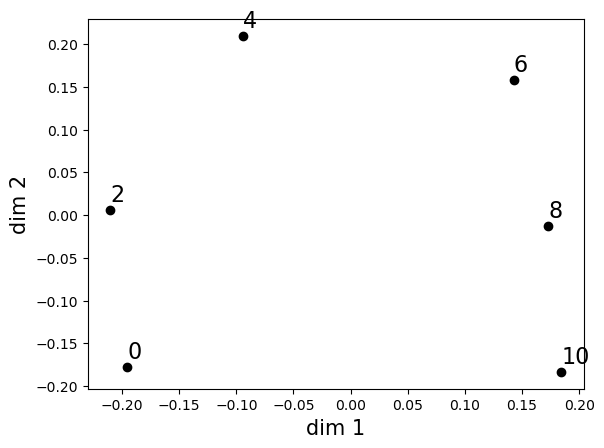

In [92]:
plt.scatter(MDS[:,0],MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],MDS[i,1]+0.01,str(int(day[i])), fontsize=16)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [93]:
from sklearn.manifold import Isomap

In [96]:
embedding = Isomap(n_neighbors=2,n_components=1)
iso = embedding.fit_transform(MDS)

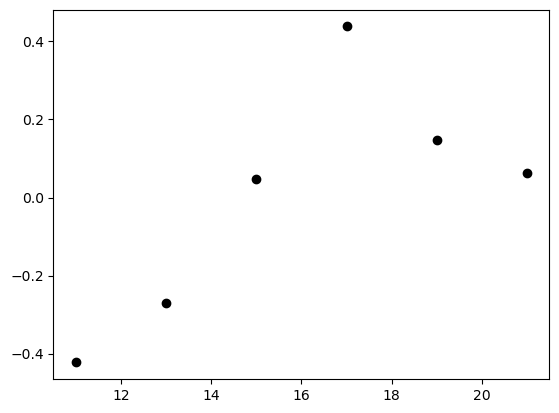

In [98]:
plt.scatter(day+11,iso,color='black')

[4, 5, 6, 7, 8, 9]